# Analyze Visitor Movement Based on Estimated Occupancies in Three Interest Areas
This note shows how do we roughly estimate the trendency of visitors' movement based on estimations of occupancy in Three Interest Areas.

To understand how do we divide video frames into Three Interest Areas which include Whole Interest Area, Core Interest Area and Margin Interest Area, please refer to [Video Processing: Division of Three Interest Areas]()

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import math
from scipy.stats import mode

# Load Estimation of Occupancy Calculated by Openpose

In [1]:
occupancy_whole = pd.read_csv('test_video_processed_occupancy_whole.csv', sep=',')
occupancy_core = pd.read_csv('test_video_processed_occupancy_core.csv', sep=',')
occupancy_margin = pd.read_csv('test_video_processed_occupancy_margin.csv', sep=',')

NameError: name 'pd' is not defined

<IPython.core.display.Javascript object>


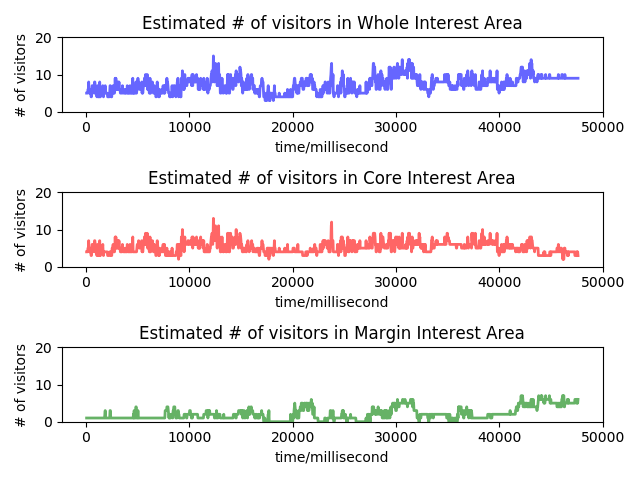

In [3]:
plt.figure()
# Whole Interest Area
plt.subplot(3, 1, 1)
plt.plot(occupancy_whole[0], occupancy_whole[1], 'b-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')
#plt.grid(True)

# Core Interest Area
plt.subplot(3, 1, 2)
plt.plot(occupancy_core[0], occupancy_core[1], 'r-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Core Interest Area')
#plt.grid(True)

# Margin Interest Area
plt.subplot(3, 1, 3)
plt.plot(occupancy_margin[0], occupancy_margin[1], 'g-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Margin Interest Area')
#plt.grid(True)

plt.tight_layout()
plt.show()

## Compare Estimated Occupancy in Whole Interest Area and the Sum of Estimated Occupancies in Core and Margin Area 

<IPython.core.display.Javascript object>


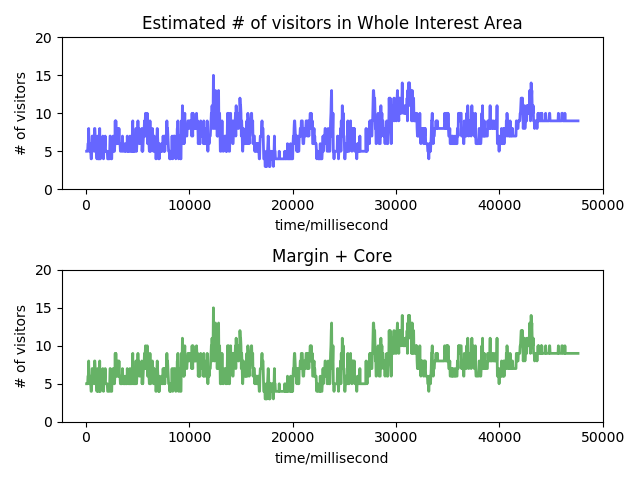

In [4]:
plt.figure()
# Whole Interest Area
plt.subplot(2,1,1)
plt.plot(occupancy_whole[0], occupancy_whole[1], 'b-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Estimated # of visitors in Whole Interest Area')
# Margin + Core Interest Area
plt.subplot(2,1,2)
plt.plot(occupancy_margin[0], occupancy_margin[1]+occupancy_core[1], 'g-', lw=2, alpha=0.6)
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=20)
plt.title('Margin + Core')
#plt.grid(True)

plt.tight_layout()
plt.show()

The time interval between two estimates is around 33 millisedonds. Thus, if we assume people will stay at the same place within one second. We can average over a sliding window of size 30.

In [5]:
print('The time interval between two estimates: {} milliseconds'.format(occupancy_whole[0][1]-occupancy_whole[0][0]))

The time interval between two estimates: 33.3326330532213 milliseconds


# Smoothen Estimations of # of Visitors in Three Areas calculated by Openpose

## Sliding Window Smoothing Method (self-defined)

In [6]:
import pdb
def moving_smoothing(values, window_size, smooth_type='mode', stride = 1):
    """
    Smoothen estimated occupancy.
    Args:
        values (pandas.DataFrame): 
            values[0]: time in millisecond
            values[1]: estimated # of visitors
        window_size(int): the size of sliding window
        smooth_type (string): 
            1. 'mode'
            2. 'mean'
            3. 'min'
            4. 'median'
        stride (int): the stride between two consecutive windows
    Returns:
        smooth_time (list): smooth time i.e. the max time in each window
        smooth_occupancy (list): smooth occupancy i.e. the mode occupancy in each window
    """
    group_time = []
    group_occupancy = []
    for i in range(0, math.ceil((len(values[0])-window_size+1)/stride)):
        group_time.append(values[0][i:i+window_size])
        group_occupancy.append(values[1][i:i+window_size])
    
    smooth_time = []
    smooth_occupancy = []
    for i in range(len(group_time)):
        smooth_time.append(min(group_time[i])) # max time in the group
        if smooth_type == 'mode':
            smooth_occupancy.append(mode(group_occupancy[i])[0][0]) # mode occupancy in the group
        elif smooth_type == 'mean':
            smooth_occupancy.append(np.round(np.mean(group_occupancy[i])))
        elif smooth_type == 'min':
            smooth_occupancy.append(np.round(np.min(group_occupancy[i])))
        elif smooth_type == 'median':
            smooth_occupancy.append(np.round(np.median(group_occupancy[i])))
        else:
            print('Please choose a proper smooth_type.')
    return smooth_time, smooth_occupancy

In [7]:
window_size = 30
smooth_type='mean'
stride = 1

<IPython.core.display.Javascript object>


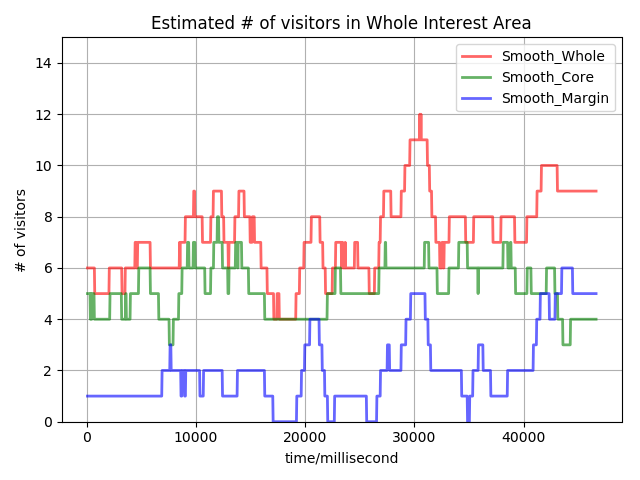

In [8]:
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

plt.figure()
# Whole Interest Area
plt.plot(smooth_time_whole, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_core, smooth_occupancy_core, 'g-', lw=2, alpha=0.6)
# Margin Interest Area
plt.plot(smooth_time_margin, smooth_occupancy_margin, 'b-', lw=2, alpha=0.6)
plt.legend(('Smooth_Whole','Smooth_Core','Smooth_Margin'))

plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=15)
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

### Smoothen then Add

<IPython.core.display.Javascript object>


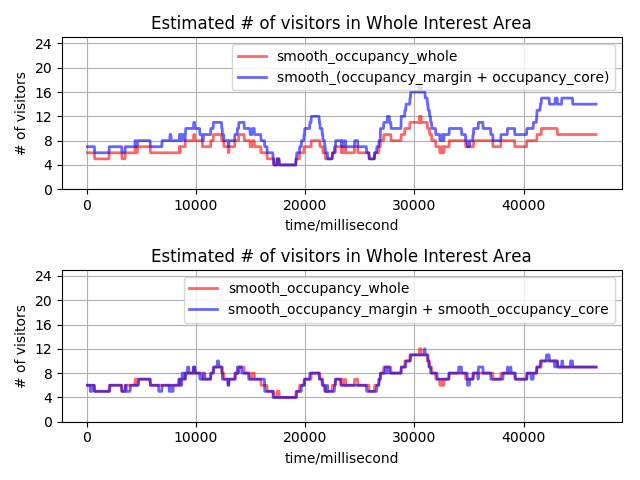

In [9]:
plt.figure()
plt.subplot(2,1,1)
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
occupancy_margin_add_core = occupancy_whole
occupancy_margin_add_core[1] = occupancy_core[1] + occupancy_margin[1]
smooth_time_margin_add_core, smooth_occupancy_margin_add_core = moving_smoothing(occupancy_margin_add_core, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_time_whole, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_margin_add_core, np.array(smooth_occupancy_margin_add_core)+np.array(smooth_occupancy_margin), 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_(occupancy_margin + occupancy_core)'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

# Add then Smoothen
plt.subplot(2,1,2)
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

# Whole Interest Area
plt.plot(smooth_time_whole, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(smooth_time_whole, np.array(smooth_occupancy_core)+np.array(smooth_occupancy_margin), 'b-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_occupancy_margin + smooth_occupancy_core'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

## Sliding Window Average Smoothing Method

In [10]:
# This is not good
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    average = np.convolve(values, weights, 'valid')
    # the average number should be int
    average = np.round(average)
    return average

In [11]:
window_size = 50

<IPython.core.display.Javascript object>


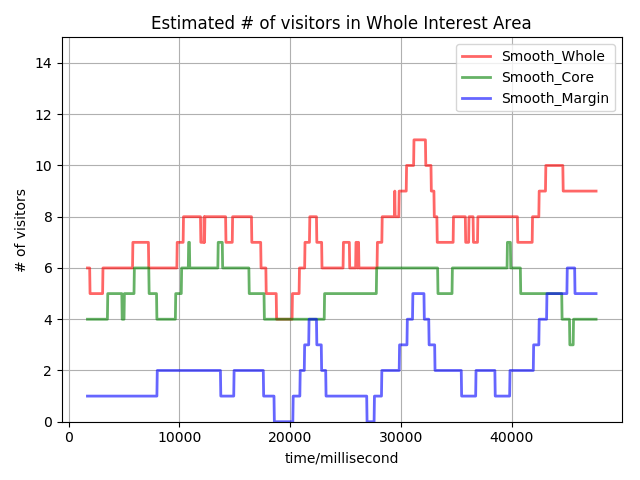

In [12]:
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_core = movingaverage(occupancy_core[1],window_size)
smooth_occupancy_margin = movingaverage(occupancy_margin[1],window_size)

plt.figure()
time = occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_whole):]
# Whole Interest Area
plt.plot(time, smooth_occupancy_whole, 'r-', lw=2, alpha=0.6)
# Core Interest Area
plt.plot(time, smooth_occupancy_core, 'g-', lw=2, alpha=0.6)
# Margin Interest Area
plt.plot(time, smooth_occupancy_margin, 'b-', lw=2, alpha=0.6)
plt.legend(('Smooth_Whole','Smooth_Core','Smooth_Margin'))

plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=15)
plt.title('Estimated # of visitors in Whole Interest Area')
plt.grid(True)

plt.tight_layout()
plt.show()

### Compare
1. subplot 1: First add seperate estimations of core and margin, then smoothen
2. subplot 2: First smoothen estimateions of core and margin seperatively, then add smoothend estimations together.

<IPython.core.display.Javascript object>


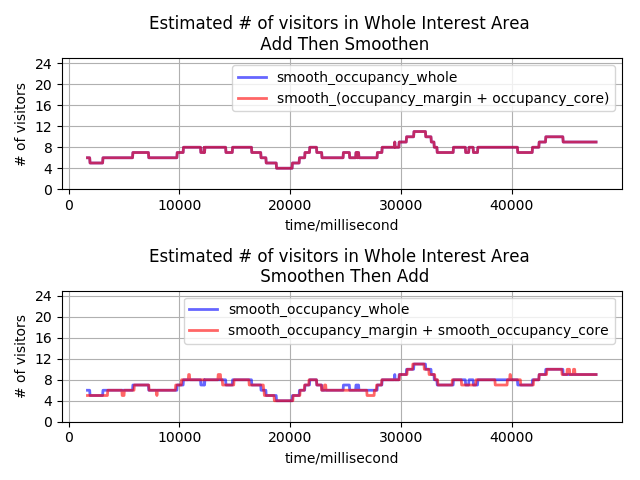

In [13]:
plt.figure()

# Add then Smoothen
plt.subplot(2,1,1)
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_margin_plus_core = movingaverage(occupancy_margin[1]+occupancy_core[1],window_size)

time = occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_whole):]
# Whole Interest Area
plt.plot(time, smooth_occupancy_whole, 'b-', lw=2, alpha=0.6)
# Margin + Core Interest Area
plt.plot(time, smooth_occupancy_margin_plus_core, 'r-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_(occupancy_margin + occupancy_core)'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area \n Add Then Smoothen')
plt.grid(True)

# Smoothen then Add
plt.subplot(2,1,2)
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_core = movingaverage(occupancy_core[1],window_size)
smooth_occupancy_margin = movingaverage(occupancy_margin[1],window_size)

time = occupancy_whole[0][len(occupancy_whole[0])-len(smooth_occupancy_whole):]
# Whole Interest Area
plt.plot(time, smooth_occupancy_whole, 'b-', lw=2, alpha=0.6)
# Margin + Core Interest Area
plt.plot(time, smooth_occupancy_core+smooth_occupancy_margin, 'r-', lw=2, alpha=0.6)
plt.legend(('smooth_occupancy_whole','smooth_occupancy_margin + smooth_occupancy_core'))
plt.xlabel('time/millisecond')
plt.ylabel('# of visitors')
plt.ylim(ymin=0, ymax=25)
plt.yticks(np.arange(0,25,step=4))
plt.title('Estimated # of visitors in Whole Interest Area \n Smoothen Then Add')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyze Visitors' Movement

## Senario Truth Value Table

Assumption: 
1. There is a time-delay for visitors to move from one area to another area.
2. At the same time step: z = x+y
3. Estimate of # of visitors in each area is independent from each other.

**First three columns** correspond the variation tendency of the number of visitors in three area i.e. Core, Margin and Whole Interest Area. 
The codes for three variation tendencies are:
* 0: hold
* 1: increase
* 2: decrease

The **forth column** indicates whether the senario possible in reality assuming the estimates of the number of visitors in three areas are accurate. Sepcifically,
* 0: impossible senario
* 1: possible senarios

The **fifth column** gives [explanation on the senario](https://github.com/UWaterloo-ASL/Openpose-Video-Analysis/blob/master/docs/Truth%20Value%20Table.pdf).

* 27 combinations
   * only 13 of 27 combinations are possible
      * only 4 of the 13 possible cases in where new visitors come in.
      * only 6 of the 13 possible cases in where visitors leave from the whole interest area.
      * Only 3 of the 13 possible cases in where the # of visitors remain unchanged.

If we have this Truth Table, and we can estimate the change of the # of visitors in each area of two consecutive time steps, we can infer which scenario is happening.


In [14]:
senarios_truth_table = pd.read_csv('analize_visitor_in_and_out_senario_truth_table.csv')
senarios_truth_table

,# of visitors in core area: x,# of visitors in margin: y,# of visitors in whole interest area: z,Truth value,Explanation
0,0,0,0,1,No people transform between space.
1,0,0,1,0,Impossible
2,0,0,2,0,Impossible
3,0,1,0,0,Impossible
4,0,1,1,0,New people come in
5,0,1,2,0,Impossible
6,0,2,0,0,Impossible
7,0,2,1,0,Impossible
8,0,2,1,1,People get out
9,1,0,0,0,Impossible


## Define function to interpret senario from occupancy estimations in Core, Margin and Whole Interest areas.

In [15]:
def interpret_senario(occupancy_core, occupancy_margin, occupancy_whole, senarios_truth_table):
    """
    Args:
        occupancy_core (list): estimation of coccupancy in core intrest area
        occupancy_margin (list): estimation of coccupancy in margin intrest area
        occupancy_whole (list): estimation of coccupancy in whole intrest area
        senarios_truth_table (pandas.DataFrame): senarios truth table which has information on
            how to interpret senario.
    Returns:
        senario_sequence (list of string):
        event_sequence (list of int):
        event_time (list of int):
    """
    senario_sequence = []
    event_sequence = []
    event_time = []
    for i in range(len(smooth_occupancy_core)-1):
        change_x = occupancy_core[i+1] - occupancy_core[i]
        change_y = occupancy_margin[i+1] - occupancy_margin[i]
        change_z = occupancy_whole[i+1] - occupancy_whole[i]
        # code: 
        #    0: hold
        #    1: increase
        #    2: decrease
        if change_x == 0:
            x = 0
        elif change_x > 0:
            x = 1
        elif change_x < 0:
            x = 2

        if change_y == 0:
            y = 0
        elif change_y > 0:
            y = 1
        elif change_y < 0:
            y = 2

        if change_z == 0:
            z = 0
        elif change_z > 0:
            z = 1
        elif change_z < 0:
            z = 2
        # convert ternary to decimal
        senario_index = z + y*3 + x*3^2
        senario_sequence.append(senarios_truth_table['Explanation'][senario_index])
        if senarios_truth_table['Truth value'][senario_index] == 0:
            event_sequence.append(0)
        else:
            event_sequence.append(senario_index)
        event_time.append(i)
    return senario_sequence, event_sequence, event_time

## Smoothing

## Sliding Window Smoothing Method (self-defined)

In [22]:
window_size = 25
smooth_type='median'
stride = 1
smooth_time_whole, smooth_occupancy_whole = moving_smoothing(occupancy_whole, window_size, smooth_type)
smooth_time_core, smooth_occupancy_core = moving_smoothing(occupancy_core, window_size, smooth_type)
smooth_time_margin, smooth_occupancy_margin = moving_smoothing(occupancy_margin, window_size, smooth_type)

<IPython.core.display.Javascript object>


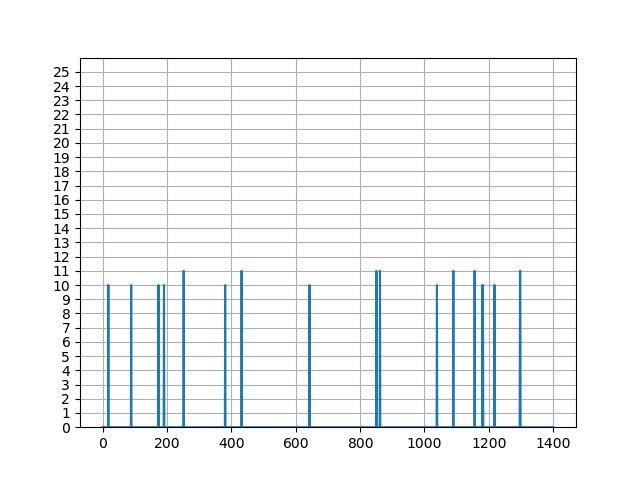

In [23]:
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, smooth_occupancy_margin, smooth_occupancy_whole, senarios_truth_table)

plt.figure()
plt.plot(np.arange(len(event_sequence)), event_sequence)
plt.ylim(ymin=0, ymax=26)
plt.yticks(np.arange(0,26,step=1))
plt.grid(True)

In [24]:
interesting_event_count = 1
for time_index in event_time:
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,occupancy_whole[0][time_index]/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.6666526610644258s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 3.0332696078431374s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 5.8665434173669455s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 6.433198179271709s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 8.466488795518208s
Explanation: People move from margin to core area and more people in margin get out of whole interest area.
*****************************************************
Detected interesting event: 


### Sliding Window Average Smoothing Method

In [25]:
window_size = 25
smooth_occupancy_whole = movingaverage(occupancy_whole[1],window_size)
smooth_occupancy_core = movingaverage(occupancy_core[1],window_size)
smooth_occupancy_margin = movingaverage(occupancy_margin[1],window_size)

<IPython.core.display.Javascript object>


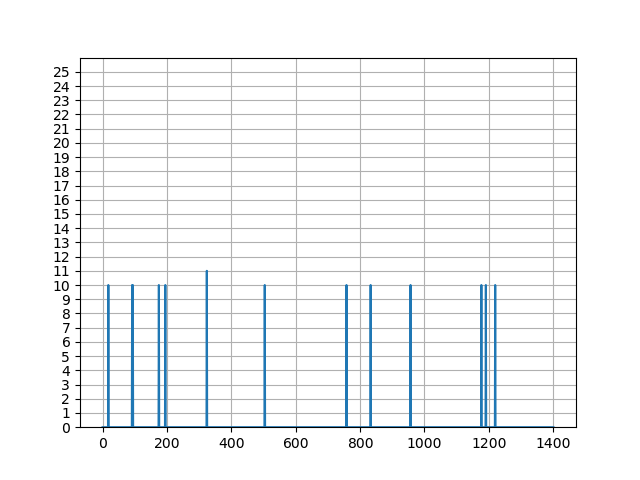

In [26]:
senario_sequence, event_sequence, event_time = interpret_senario(smooth_occupancy_core, smooth_occupancy_margin, smooth_occupancy_whole, senarios_truth_table)

plt.figure()
plt.plot(np.arange(len(event_sequence)), event_sequence)
plt.ylim(ymin=0, ymax=26)
plt.yticks(np.arange(0,26,step=1))
plt.grid(True)

In [27]:
interesting_event_count = 1
for time_index in event_time:
    if event_sequence[time_index] != 0:
        print('Detected interesting event: {},    Time: {}s'.format(interesting_event_count,occupancy_whole[0][time_index]/1000))
        print('Explanation: {}'.format(senario_sequence[time_index]))
        print('*****************************************************')
        interesting_event_count += 1

Detected interesting event: 1,    Time: 0.6666526610644258s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 2,    Time: 3.1332675070028007s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 3,    Time: 3.1999327731092437s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 4,    Time: 5.899876050420168s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 5,    Time: 6.566528711484593s
Explanation: New people come in and people move from margin to core area.
*****************************************************
Detected interesting event: 6,    Time: 10.86643837535014s
Exp

# Check on Video
To check the video, please go to [YouTube: Analyze Visitor Movement Independently Analyze Three Interest Areas](https://youtu.be/0oeBmNfOuEk).
1. If we look at the video, we might find that moving from one interesting area to another for people might take less than one second or even less than half second.
2. One big probelm is the analyzing of these three interesting areas is independently done using openpose. (But for those don't make sense case, the Truth Value is 0. So, should be OK. ?? Not very sure.) ***Let's test one single Openpose Analysis. And use the position of visitor's center of mass to decide whether should he/she be in Margin or Core Interet Area.*